### Import các thư viện cần thiết

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import ipywidgets as widgets
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from datetime import datetime
from dateutil import parser
from IPython.display import display, Markdown

In [2]:
df = pd.read_csv("../data/processed/air_quality_processed.csv")

# Câu hỏi 5: Nếu nguồn lực quan trắc hạn chế, nên ưu tiên giám sát chất ô nhiễm nào (2–3 chất) để phản ánh rủi ro AQI hiệu quả nhất?

## 1. The Question
Trong điều kiện chỉ có thể triển khai **2–3 cảm biến** vì hạn chế ngân sách/vận hành, **những chất ô nhiễm nào** nên được ưu tiên giám sát để **phản ánh rủi ro AQI** hiệu quả và ổn định nhất trên dữ liệu quan trắc (2016–2024)?
Chúng tôi đánh giá từng chất theo 3 tiêu chí đo lường được:

- **(T1) Correlation với AQI:** chất nào có tương quan mạnh với `aqi` (Pearson + Spearman)?
- **(T2) Status separation:** nồng độ chất đó có tăng/giảm có trật tự theo các mức `status` (Good → … → Hazardous) hay không?
- **(T3) Across-site consistency:** mối liên hệ với `aqi` có ổn định trên nhiều `siteid` hay chỉ mạnh ở một vài trạm?

> Lưu ý: các biến dạng `*_avg` hoặc `*_8hr` là biến tổng hợp theo chuẩn AQI (đại diện tín hiệu theo cửa sổ thời gian). Khuyến nghị cuối cùng sẽ quy về **chất cần lắp cảm biến** (PM2.5/PM10/CO/…).

## 2. Motivation & Benefits
Nhiều địa phương không thể lắp đủ cảm biến cho tất cả chất ô nhiễm. Việc chọn đúng 2–3 chất ưu tiên sẽ:
- **tối ưu chi phí quan trắc** và công bảo trì,
- **nâng hiệu quả cảnh báo sức khỏe cộng đồng**,
- và biến kết quả EDA thành **đề xuất vận hành thực tiễn** (triển khai cảm biến “đúng chỗ, đúng chất”).

> Phân tích trong câu hỏi này nhằm chọn **chất phản ánh rủi ro AQI tốt** (proxy). Đây là phân tích theo quan sát dữ liệu, **không suy diễn quan hệ nhân quả**.

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation

Trước khi phân tích Câu 5, cần chuẩn bị dữ liệu để đảm bảo các phép đo “độ liên hệ” giữa **AQI** và các **chất ô nhiễm** là đáng tin cậy và chạy được ổn định trên dữ liệu lớn.

1) **Xác định biến mục tiêu (target)**
- Chọn `aqi` làm biến mục tiêu vì đây là chỉ số tổng hợp phản ánh mức rủi ro chất lượng không khí.

2) **Chuẩn hoá danh sách biến ứng viên (candidate pollutants)**
- Dữ liệu có thể chứa nhiều phiên bản của cùng một chất (ví dụ: cột **raw** theo giờ và cột **aggregate** như `*_avg` hoặc `*_8hr`).
- Vì vậy, tạo `candidate_cols` gồm cả **aggregate + raw** để không bỏ sót tín hiệu quan trọng (PM2.5, PM10, O3, CO, SO2, NO2/NO/NOx,…).

3) **Lọc chỉ các cột thực sự tồn tại trong dataset**
- Không phải dataset nào cũng có đủ tất cả cột trong danh sách ứng viên.
- Do đó dùng bước: `candidate_cols = [c for c in candidate_cols if c in df.columns]`
  để tránh lỗi thiếu cột và đảm bảo pipeline có thể chạy trên mọi phiên bản dữ liệu.

Kết quả của bước tiền xử lý này là một danh sách `candidate_cols` “sạch” gồm các chất ô nhiễm sẵn có,
dùng trực tiếp cho phần tính toán tương quan / xếp hạng ưu tiên ở các bước tiếp theo.

### A.2 Code Implementation

In [3]:
# Chọn danh sách biến ứng viên (giữ cả aggregate + raw nếu có)
target = "aqi"
candidate_cols = [
    "pm2.5_avg", "pm10_avg", "o3_8hr", "co_8hr", "so2_avg",
    "pm2.5", "pm10", "o3", "co", "so2", "no2", "nox", "no",
]
candidate_cols = [c for c in candidate_cols if c in df.columns]

## B. Data Analysis
### B.1 Written Explanation
**Mục tiêu:** Với nguồn lực giám sát hạn chế, xác định 2-3 chất gây ô nhiễm phản ánh tốt nhất **rủi ro AQI** trong tập dữ liệu này.

Chúng tôi đánh giá từng chất gây ô nhiễm tiềm năng bằng cách sử dụng **ba tiêu chí bổ sung**:

1) **Mối tương quan với AQI (cường độ tín hiệu toàn cầu)**
- **Phương pháp:** tính toán hệ số tương quan Pearson và Spearman giữa mỗi chất gây ô nhiễm và `aqi`.

- **Lý do:** Pearson thể hiện mối liên hệ tuyến tính; Spearman thể hiện mối liên hệ đơn điệu và mạnh mẽ hơn đối với độ lệch/giá trị ngoại lệ.

- **Kết quả dự kiến:** Bảng xếp hạng các chất gây ô nhiễm theo hệ số tương quan (Pearson + Spearman).

- **Biểu đồ 1:** biểu đồ cột của k hệ số tương quan Pearson hàng đầu.

2) **Phân loại mức độ rủi ro theo trạng thái AQI (khả năng diễn giải thực tiễn)**
- **Phương pháp:** so sánh mức độ ô nhiễm giữa các nhóm `trạng thái` được sắp xếp theo thứ tự bằng cách sử dụng:

- trung vị/trung bình cho mỗi trạng thái (trung vị là yếu tố chính),

- hệ số tương quan Spearman giữa chất ô nhiễm và `status_rank`.

- **Lý do:** các trạng thái rủi ro cao rất hiếm; **trung vị** ổn định hơn trung bình khi có sự mất cân bằng/ngoại lệ.

- **Kết quả mong đợi:**  Bảng tóm tắt số lượng/trung vị/trung bình theo trạng thái; Bảng xếp hạng theo hệ số tương quan Spearman so với `status_rank`.

- **Biểu đồ 2:** biểu đồ đường trung vị theo trạng thái cho các chất ô nhiễm có tương quan cao nhất.

3) **Tính ổn định giữa các địa điểm (độ bền vững khi triển khai)**
- **Phương pháp:** tính toán hệ số tương quan Pearson giữa mỗi chất ô nhiễm và AQI **trong mỗi địa điểm** (`siteid`) đối với các địa điểm có đủ mẫu.
Tổng hợp trên các địa điểm bằng cách sử dụng:

- `median_r` (cường độ điển hình),

- `iqr_r` (biến thiên giữa các địa điểm),

- `% (r > 0,5)` (tần suất tương quan mạnh).

- **Lý do:** Một chất gây ô nhiễm chỉ hữu ích về mặt vận hành nếu mối quan hệ của nó với AQI **nhất quán giữa các trạm**, không bị chi phối bởi một vài địa điểm.

- **Kết quả mong đợi:** Bảng tóm tắt độ ổn định tại địa điểm cho mỗi chất gây ô nhiễm.

- **Biểu đồ 3:** phân bố các tương quan trên mỗi địa điểm (biểu đồ hộp) cho các ứng viên hàng đầu.

Cuối cùng, chúng tôi kết hợp bằng chứng từ (1)–(3) để đề xuất **2–3 chất gây ô nhiễm hàng đầu** cần ưu tiên.
### B.2 Code Implementation
## Tiêu chí 1 - Tương quan với AQI (Pearson + Spearman)

In [4]:
corr_rows = []
for col in candidate_cols:
    tmp = df[[target, col]].dropna()
    if len(tmp) < 1000:
        continue
    pearson = tmp[target].corr(tmp[col], method="pearson")
    spearman = tmp[target].corr(tmp[col], method="spearman")
    corr_rows.append({
        "variable": col,
        "n": len(tmp),
        "pearson_r": pearson,
        "spearman_r": spearman
    })

corr_df = pd.DataFrame(corr_rows).sort_values("pearson_r", ascending=False)
top_k = 10
top_corr = corr_df.head(top_k).copy()

out_table = widgets.Output()
out_plot  = widgets.Output()

with out_table:
    display(corr_df) 

with out_plot:
    plt.figure(figsize=(7, 4))
    plt.bar(top_corr["variable"], top_corr["pearson_r"])
    plt.title(f"Top {top_k} biến tương quan Pearson voi AQI")
    plt.xlabel("Biến")
    plt.ylabel("Pearson r")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

display(widgets.HBox([out_table, out_plot]))

### Kết luận từ Tương quan với AQI (Pearson + Spearman)

#### Kết quả chính (từ `corr_df`)
Trên toàn bộ tập dữ liệu sau tiền xử lý (**n = 5,530,918** dòng cho mỗi biến), thứ hạng tương quan Pearson với `aqi` như sau:

**Nhóm mạnh nhất**
- `pm2.5_avg`: **r = 0.951** (Spearman ≈ **0.941**) → mạnh nhất, gần như “đại diện” cho AQI
- `pm2.5`: r = 0.858 (Spearman ≈ 0.850)
- `pm10_avg`: r = 0.851 (Spearman ≈ 0.855)
- `pm10`: r = 0.768 (Spearman ≈ 0.786)

**Nhóm trung bình**
- `co_8hr`: r = 0.399 (Spearman ≈ 0.536)
- `o3_8hr`: r = 0.358 (Spearman ≈ 0.369)
- `no2`: r = 0.344 (Spearman ≈ 0.378)
- `co`: r = 0.343 (Spearman ≈ 0.509)
- `so2_avg`: r = 0.326 (Spearman ≈ 0.331)

**Nhóm yếu**
- `o3`: r = 0.297
- `so2`: r = 0.292
- `nox`: r = 0.216
- `no`: r = 0.028 (gần như không liên hệ với AQI trong tập dữ liệu này)

#### Diễn giải ý nghĩa
>**(1) PM2.5 là biến “tín hiệu mạnh nhất” của rủi ro AQI**  
`pm2.5_avg` có tương quan gần như cực đại với `aqi` (r ≈ 0.95), cho thấy nếu chỉ được chọn **1 cảm biến**, PM2.5 (đặc biệt dạng average theo chuẩn AQI) là lựa chọn “đáng tiền” nhất để phản ánh mức rủi ro.

>**(2) Các biến “avg/8hr” thường mạnh hơn biến raw**  
Ví dụ: `pm2.5_avg` > `pm2.5`, `pm10_avg` > `pm10`, `co_8hr` > `co` (theo Pearson).  
Điều này hợp lý vì các biến `*_avg` / `_8hr` là dạng đã “làm mượt theo chuẩn AQI”, nên bám sát cơ chế phản ánh mức độ rủi ro hơn.

>**(3) CO có dấu hiệu quan hệ không tuyến tính / chịu ảnh hưởng ngoại lai**  
Với CO: Pearson chỉ ≈0.34 nhưng Spearman cao hơn (≈0.51)  
→ gợi ý CO có quan hệ dạng **đơn điệu nhưng không tuyến tính** (hoặc bị kéo bởi outliers/đuôi dài). Nếu xét vai trò “bổ sung” ngoài PM, CO (đặc biệt `co_8hr`) là ứng viên hợp lý để xem tiếp ở tiêu chí 2–3.

>**(4) NO gần như không giúp phản ánh AQI tổng**  
`no` có r ≈ 0.028, Spearman ≈ 0.007 → trong dataset này, NO không phải lựa chọn tốt nếu mục tiêu là “phản ánh rủi ro AQI”.

#### Kết luận tạm thời từ Tiêu chí 1 
Nếu chỉ dựa trên tương quan với AQI, top ứng viên để ưu tiên giám sát sẽ là:

- **Ưu tiên chắc chắn:** PM2.5 (đặc biệt `pm2.5_avg`)
- **Ưu tiên tiếp theo:** PM10 (đặc biệt `pm10_avg`)
- **Nhóm cân nhắc làm cảm biến thứ 3:** `co_8hr` / `o3_8hr` / `no2`  
  (trong đó `co_8hr` nổi bật vì Spearman cao → có thể phản ánh rủi ro tốt theo hướng “tăng/giảm theo mức AQI” dù không tuyến tính)

## Tiêu chí 2 - Khả năng phân biệt theo mức rủi ro
Trong tiêu chí 2, mục tiêu là kiểm tra: **khi AQI chuyển từ Good → Hazardous thì nồng độ từng chất có thay đổi “có trật tự” và đủ rõ để phân biệt mức rủi ro hay không**. Vì các nhóm rủi ro cao thường hiếm, chúng tôi dùng **median** (ổn định hơn mean) và bổ sung **cỡ mẫu theo status** để tránh kết luận sai do nhóm hiếm.
### 2.1. Median theo `status` + biểu đồ median  

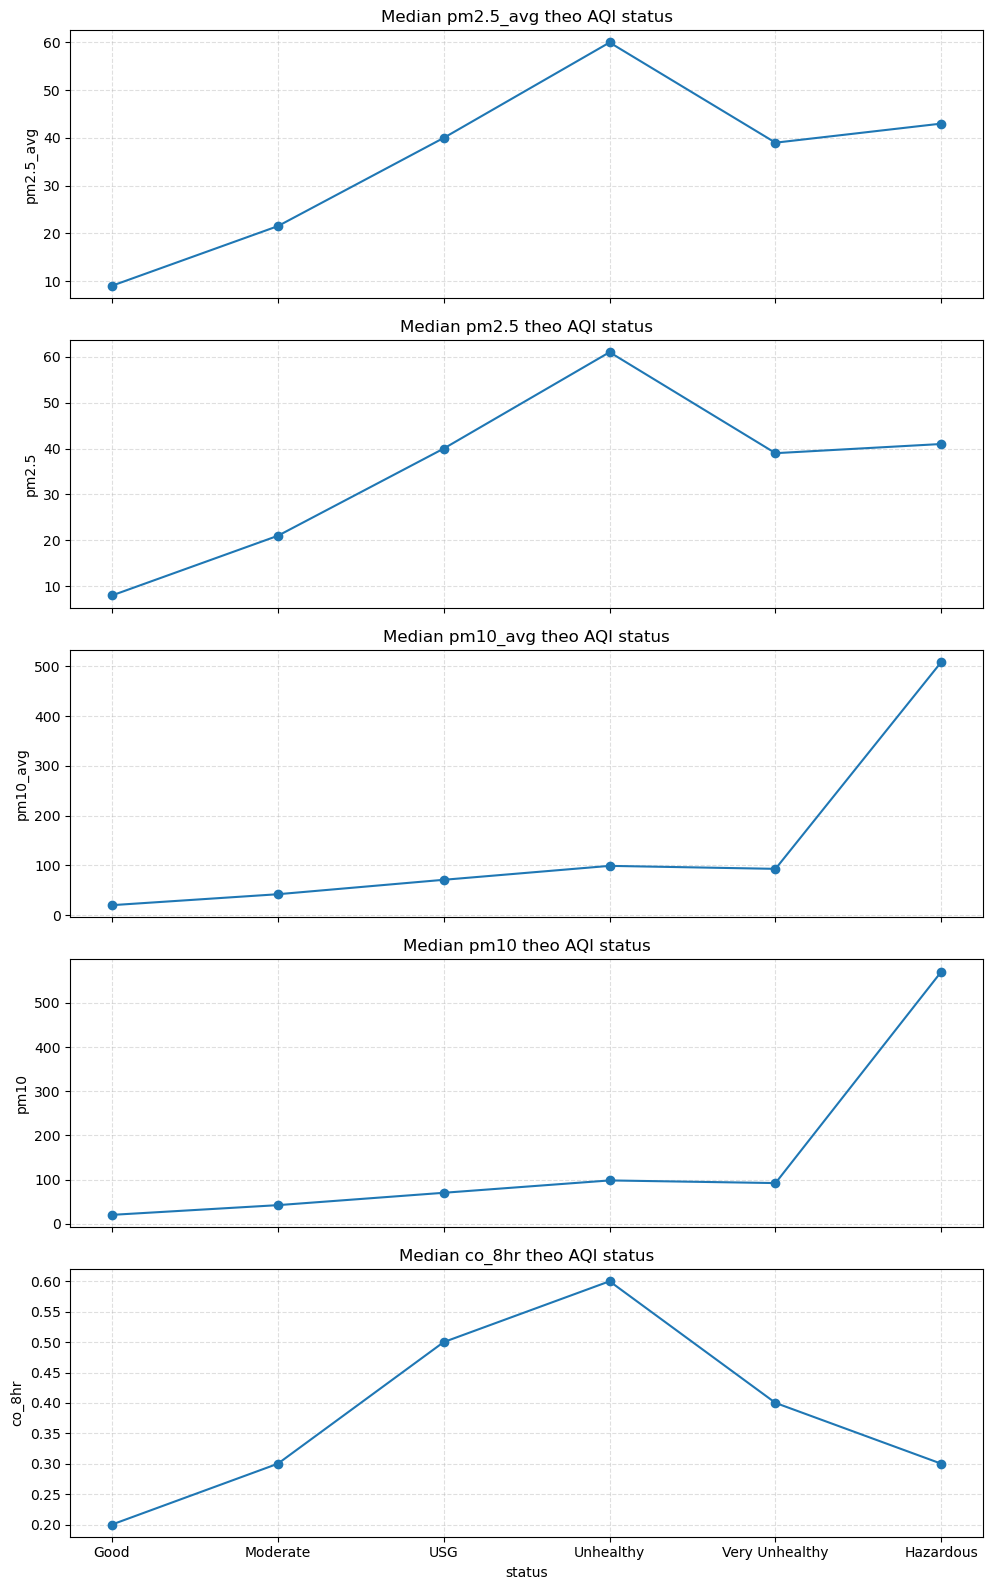

In [5]:
# 1) Thứ tự status (giữ đúng thứ tự AQI)
status_order = [
    "Good",
    "Moderate",
    "Unhealthy for sensitive groups",
    "Unhealthy",
    "Very Unhealthy",
    "Hazardous",
]
short_labels = {
    "Good": "Good",
    "Moderate": "Moderate",
    "Unhealthy for sensitive groups": "USG",
    "Unhealthy": "Unhealthy",
    "Very Unhealthy": "Very Unhealthy",
    "Hazardous": "Hazardous",
}
x_labels = [short_labels[s] for s in status_order]

# 2) Chọn 5 biến để vẽ (bạn có thể dùng corr_df.head(5) như cũ)
top_vars = ["pm2.5_avg", "pm2.5", "pm10_avg", "pm10", "co_8hr"]
top_vars = [c for c in top_vars if c in df.columns]

# 3) Ép status thành categorical ordered để groupby đúng thứ tự
df["status"] = pd.Categorical(df["status"], categories=status_order, ordered=True)

# 4) Tính median theo status cho tất cả biến một lần (rất gọn)
# Fix FutureWarning: set observed=False để giữ hành vi hiện tại của pandas
med = (
    df.groupby("status", observed=False)[top_vars]
      .median()
      .reindex(status_order)
)

# 5) Vẽ 5 biểu đồ dọc (mỗi biến 1 plot)
fig, axes = plt.subplots(nrows=len(top_vars), ncols=1, figsize=(10, 3.2 * len(top_vars)), sharex=True)
if len(top_vars) == 1:
    axes = [axes]

for ax, col in zip(axes, top_vars):
    ax.plot(range(len(status_order)), med[col].values, marker="o")
    ax.set_title(f"Median {col} theo AQI status")
    ax.set_ylabel(col)
    ax.grid(True, linestyle="--", alpha=0.4)

axes[-1].set_xlabel("status")
axes[-1].set_xticks(range(len(status_order)))
axes[-1].set_xticklabels(x_labels, rotation=0)
plt.tight_layout()
plt.show()

Quan sát median theo từng mức `status` (và plot median):

- **PM2.5 (pm2.5_avg / pm2.5)** tăng rõ rệt theo mức rủi ro từ Good → Moderate → USG → Unhealthy.  
    Điều này cho thấy **PM2.5 tách mức rủi ro tốt** ở các mức phổ biến (đến Unhealthy).
    Ở **Very Unhealthy/Hazardous** đường bị “gãy/không tăng tiếp”, khả năng cao do nhóm cực cao rất hiếm nên median kém ổn định.
- **PM10 (pm10_avg / pm10)** cũng tăng dần từ **Good → Unhealthy**, và đặc biệt bùng lên rất mạnh ở Hazardous.
    Điều này gợi ý **PM10 rất nhạy với các “episode bụi cực đoan” (dust events)**, nên hữu ích để bắt các đợt rủi ro rất cao.
    Tương tự, đoạn **Very Unhealthy/Hazardous** có thể dao động do hiếm mẫu.

- **CO (co_8hr)**: tăng dần đến khoảng **Unhealthy**, nhưng sau đó giảm ở **Very Unhealthy** và **Hazardous**.
  Nghĩa là **CO (8hr) không tăng đơn điệu theo status** trong toàn dải; nó phù hợp hơn như tín hiệu bổ sung (đặc biệt ở vùng rủi ro trung bình), chứ không phải “trục chính” để phân biệt toàn bộ mức AQI.

> Kết luận **Tiêu chí 2 (theo plot)**:
>- **PM2.5** là biến tách mức rủi ro **ổn định nhất** ở dải status phổ biến (Good → Unhealthy).
>- **PM10** bổ trợ mạnh cho việc bắt **rủi ro cực đoan** (Hazardous).
>- **CO_8hr** mang tính **bổ sung**, vì trend không giữ được đơn điệu ở mức rất cao.

## Tiêu chí 3: Tính ổn định theo không gian (Across-site consistency)

Trong thực tế, nếu một chất “phản ánh AQI tốt” thì mối liên hệ đó nên **ổn định ở nhiều trạm đo (siteid)**, không chỉ mạnh ở một vài nơi.  
Vì vậy, ở tiêu chí 3 chúng ta:

- Tính **Pearson correlation giữa từng chất và `aqi` riêng cho từng `siteid`** (chỉ giữ các site có đủ mẫu, `n >= 2000`).
- Sau đó tổng hợp theo từng chất bằng:
  - `median_r`: trung vị tương quan (đại diện mức liên hệ điển hình trên các site)
  - `iqr_r`: IQR của tương quan (độ dao động theo site, càng nhỏ càng ổn định)
  - `% r > 0.5`: tỷ lệ site có tương quan mạnh (thước đo “phổ quát”)

> Lưu ý: Chúng ta dùng **median + IQR** vì tương quan theo site có thể bị lệch bởi một vài trạm đặc biệt/outlier.

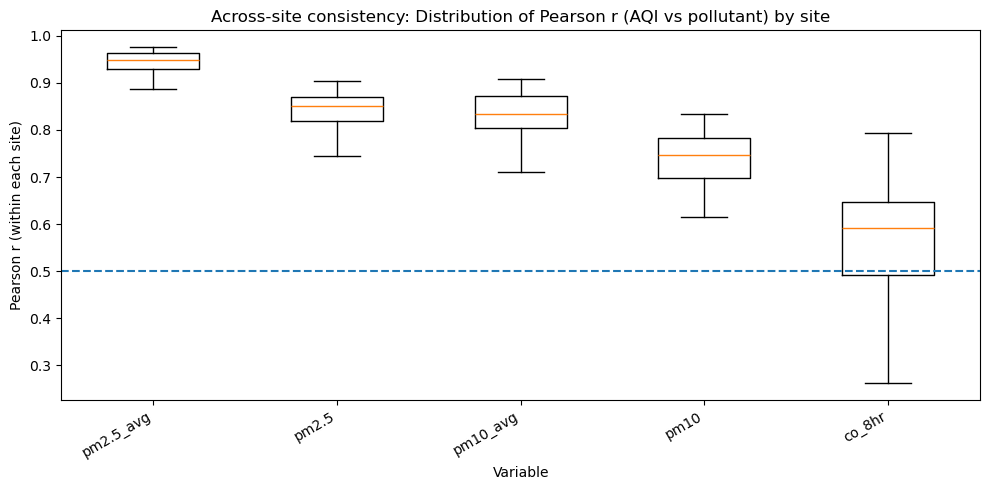

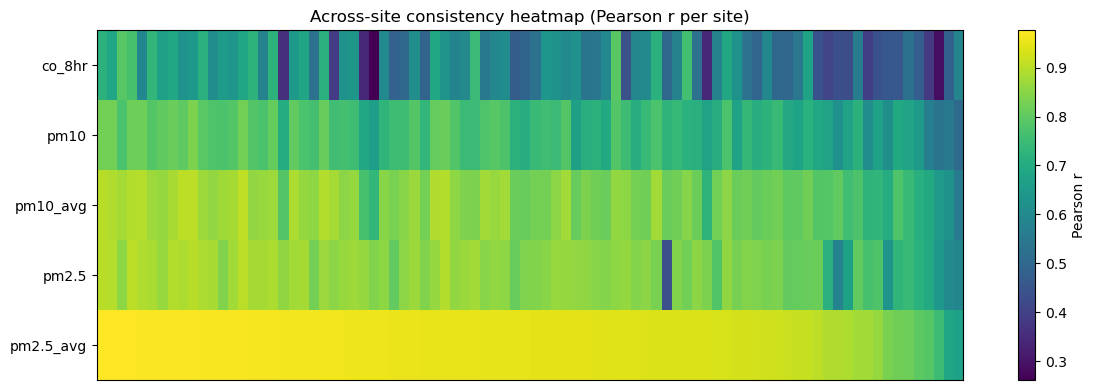

In [6]:
site_col = "siteid"
MIN_N_PER_SITE = 2000

# Chọn vài biến tiêu biểu để vẽ (gợi ý: top 5 của corr_df hoặc tự chọn)
top_vars = ["pm2.5_avg", "pm2.5", "pm10_avg", "pm10", "co_8hr"]
top_vars = [c for c in top_vars if c in df.columns]

# ===== 1) Tính Pearson r theo từng site cho từng biến (không in ra) =====
site_scores = []

# Chỉ lấy những cột cần thiết để dropna nhanh hơn
need_cols = [site_col, target] + top_vars
tmp_df = df[need_cols].dropna(subset=[site_col, target])

for col in top_vars:
    d = tmp_df[[site_col, target, col]].dropna()
    for site_id, g in d.groupby(site_col):
        if len(g) < MIN_N_PER_SITE:
            continue
        r = g[target].corr(g[col], method="pearson")
        site_scores.append({"variable": col, "siteid": site_id, "pearson_r": r})

site_scores_df = pd.DataFrame(site_scores)

# Nếu dataset có site quá ít sau lọc
if site_scores_df.empty:
    raise ValueError("Khong co site nao du mau (n>=2000) sau khi loc. Hay giam MIN_N_PER_SITE hoac kiem tra du lieu.")

# ===== 2) PLOT A: Boxplot phân bố r theo site (độ ổn định = hộp hẹp) =====
fig, ax = plt.subplots(figsize=(10, 5))
data = [site_scores_df.loc[site_scores_df["variable"] == v, "pearson_r"].values for v in top_vars]

ax.boxplot(data, labels=top_vars, showfliers=False)
ax.axhline(0.5, linestyle="--")  # ngưỡng tham khảo (không cần nói số trong nhận xét nếu bạn không muốn)
ax.set_title("Across-site consistency: Distribution of Pearson r (AQI vs pollutant) by site")
ax.set_xlabel("Variable")
ax.set_ylabel("Pearson r (within each site)")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

# ===== 3) PLOT B: Heatmap variable × site (nhìn tính 'phổ quát') =====
# Pivot thành ma trận: rows=variable, cols=siteid
pivot = site_scores_df.pivot(index="variable", columns="siteid", values="pearson_r")

# Sắp xếp site theo mức r trung bình của PM2.5_avg (nếu có) để heatmap dễ nhìn
sort_ref = "pm2.5_avg" if "pm2.5_avg" in pivot.index else pivot.index[0]
site_order = pivot.loc[sort_ref].sort_values(ascending=False).index
pivot = pivot[site_order]

fig, ax = plt.subplots(figsize=(12, 4))
im = ax.imshow(pivot.values, aspect="auto")  # không set màu cụ thể theo yêu cầu bạn

ax.set_title("Across-site consistency heatmap (Pearson r per site)")
ax.set_yticks(range(len(pivot.index)))
ax.set_yticklabels(pivot.index)
ax.set_xticks([])  # nhiều site -> bỏ nhãn cho gọn
plt.colorbar(im, ax=ax, label="Pearson r")
plt.tight_layout()
plt.show()


### Nhận xét Boxplot phân bố Pearson r theo từng site
Plot A cho thấy “độ bền theo không gian” của mối liên hệ giữa AQI và từng chất (mỗi hộp là phân bố hệ số tương quan theo các trạm đo):

- **pm2.5_avg nổi bật nhất về tính ổn định**  
  Hộp **nằm rất cao** và **rất hẹp** (IQR nhỏ), whisker cũng ngắn → nghĩa là **gần như mọi site đều cho tương quan mạnh và khá đồng nhất**.  
  Đây là dấu hiệu “đúng chất – đúng mọi nơi”: hiệu quả không phụ thuộc một vài trạm đặc biệt.

- **pm2.5 và pm10_avg cũng rất tốt, nhưng biến thiên lớn hơn pm2.5_avg**  
  Hai hộp vẫn **nằm cao** (đa số site mạnh), nhưng **rộng hơn** → có sự khác biệt giữa các địa điểm (vẫn ổn, nhưng không “đồng đều tuyệt đối” như pm2.5_avg).  
  Điều này hợp lý: dữ liệu theo site khác nhau về nguồn phát thải/địa hình/khí tượng nên mức độ bám AQI có dao động.

- **pm10 yếu hơn nhóm trên về độ bền**  
  Median thấp hơn và hộp rộng hơn pm2.5/pm10_avg → **mối liên hệ với AQI kém “đồng nhất” hơn**.  
  Tuy vậy, phần lớn phân bố vẫn nằm ở vùng tương quan khá tốt → PM10 vẫn là ứng viên mạnh, nhưng tính ổn định “kém hơn PM2.5”.

- **co_8hr biến thiên mạnh nhất và có site rất yếu**  
  Hộp **rộng**, whisker dài và có phần rơi xuống thấp hơn rõ rệt → nghĩa là **CO có nơi liên hệ với AQI khá tốt, nhưng cũng có nơi rất kém**.  
  Nói cách khác, **CO không “phổ quát”** như PM: dùng tốt trong một số ngữ cảnh (đô thị/giao thông/đốt), nhưng không đảm bảo hiệu quả đồng đều trên mọi trạm.

- **Đường gạch (ngưỡng tham khảo)** cho thấy nhanh mức “tương quan đủ mạnh”:  
  Nhóm PM gần như luôn vượt ngưỡng này; **co_8hr** thì có một phần đáng kể “chạm/tiệm cận/đi xuống” → củng cố kết luận CO chỉ nên là **cảm biến bổ sung**.

> Tóm lại từ Plot A: **PM2.5 (đặc biệt dạng avg) là ổn định nhất**, kế đến **PM10/PM10_avg**, còn **CO_8hr có tính phụ thuộc địa điểm cao**.

---

### Nhận xét Heatmap Pearson r (biến × site)
Heatmap giúp nhìn “tính phổ quát” trực quan hơn: nếu một biến mạnh và ổn định, hàng của nó sẽ **sáng đều** trên nhiều cột (nhiều site).

- **Hàng pm2.5_avg gần như sáng đồng đều trên toàn bộ các site**  
  Đây là dấu hiệu rõ nhất của “across-site consistency”: **không chỉ mạnh**, mà còn **đồng đều**.

- **pm2.5 và pm10_avg: phần lớn vẫn sáng, nhưng xuất hiện một vài dải tối hơn**  
  Điều này cho thấy đa số trạm vẫn có tương quan mạnh, tuy nhiên có **một số site/nhóm site** mà mối liên hệ giảm (có thể do đặc thù địa phương, sai khác điều kiện khuếch tán, cấu trúc nguồn thải hoặc chất lượng đo).

- **pm10 có gradient tối hơn rõ rệt so với pm10_avg**  
  Hàng pm10 nhìn chung “xanh hơn” (kém sáng hơn) → mức bám AQI **kém ổn định hơn** so với biến tổng hợp (avg).  
  Đây cũng là lý do trong triển khai thực tế, PM10 có thể tốt để bắt “episode bụi”, nhưng độ đồng đều theo site không bằng PM2.5.

- **co_8hr là hàng “loang lổ” nhất**  
  Xen kẽ vùng sáng–tối theo site → khẳng định mạnh rằng CO **không ổn định theo không gian**: có nơi đóng vai trò mạnh, có nơi gần như không phản ánh AQI tốt.

- **Vì các site được sắp theo mức mạnh của biến tham chiếu**, nên ở phía cuối heatmap (một nhóm site) các hàng có xu hướng tối hơn:  
  Điều này cho thấy **có những cụm trạm mà tất cả biến đều “bám AQI kém hơn”**, nhưng mức suy giảm của CO rõ nhất, còn PM2.5_avg vẫn giữ được độ sáng tương đối tốt.

---

### Kết luận từ 2 plot
- **PM2.5 là lựa chọn “an toàn và phổ quát” nhất** vì vừa mạnh vừa ổn định trên gần như mọi site.  
- **PM10 (hoặc PM10_avg)** là lựa chọn thứ hai hợp lý để bổ sung, nhất là để bắt các tình huống bụi mạnh.  
- **CO_8hr** nên được xem là **cảm biến thứ ba tùy bối cảnh** (đặc thù giao thông/đốt cháy), vì tính ổn định theo site kém hơn rõ rệt so với nhóm PM.


## C. Results & Interpretation 

Mục tiêu của Câu hỏi 5 là đưa ra một khuyến nghị **có thể triển khai được trong thực tế**: nếu chỉ có thể lắp **2–3 cảm biến**, thì nên chọn chất nào để phản ánh rủi ro AQI **mạnh – dễ diễn giải – và bền vững giữa các trạm**. Ba tiêu chí (T1–T3) đã cung cấp ba “lớp bằng chứng” khác nhau và kết quả cuối cùng **hội tụ nhất quán** về cùng một nhóm biến.

---

### (1) Tín hiệu toàn cục: PM2.5 là “proxy” mạnh nhất của AQI (Tiêu chí 1)
Trong toàn bộ tập dữ liệu sau tiền xử lý (hơn **5.5 triệu** quan sát), **pm2.5_avg** có tương quan với AQI gần như cực đại (**Pearson ≈ 0.95, Spearman ≈ 0.94**). Đây là dấu hiệu rất mạnh cho thấy: **nếu buộc phải chọn 1 cảm biến duy nhất để đại diện rủi ro AQI, PM2.5 là lựa chọn “đáng tiền” nhất**.

Ngoài ra, **PM10 (đặc biệt pm10_avg)** cũng nằm trong nhóm tương quan cao (xếp ngay sau PM2.5), trong khi các khí như **CO, NO2, O3** chỉ đạt mức tương quan trung bình hoặc yếu hơn đáng kể. Đặc biệt, **NO gần như không liên hệ với AQI** trong tập dữ liệu này, nên không phù hợp làm biến “đại diện rủi ro”.

> Diễn giải: **PM2.5 và PM10 là hai tín hiệu bám sát AQI nhất khi nhìn ở quy mô toàn bộ dữ liệu**.

---

### (2) Khả năng “tách mức rủi ro”: PM2.5 ổn định nhất trong dải status phổ biến; PM10 nhạy với cực trị (Tiêu chí 2)
Các biểu đồ median theo **status** cho thấy:

- **PM2.5 (avg và raw)** tăng rõ rệt và “có trật tự” từ **Good → Moderate → USG → Unhealthy**.  
  Điều này quan trọng vì đây là những mức xuất hiện thường xuyên nhất trong dữ liệu: PM2.5 giúp **phân biệt rủi ro một cách ổn định ở vùng mà hệ thống cảnh báo hoạt động nhiều nhất**.

- **PM10 (avg và raw)** cũng tăng dần theo status và có xu hướng **bùng mạnh ở Hazardous**, gợi ý PM10 đặc biệt hữu ích để **bắt các “episode bụi cực đoan”** (dust events) – đúng với vai trò thực tế của PM10.

- **CO_8hr** tăng đến khoảng Unhealthy nhưng không giữ được xu hướng tăng đơn điệu ở các mức rất cao (Very Unhealthy/Hazardous). Điều này cho thấy CO **không phải trục chính để phân tách toàn bộ dải rủi ro**, nhưng vẫn có giá trị như **tín hiệu bổ sung** trong một số bối cảnh.

> Diễn giải: **PM2.5 là biến “tách rủi ro” tốt và ổn định nhất ở dải phổ biến; PM10 bổ sung mạnh cho các đợt cực trị. CO phù hợp hơn ở vai trò phụ trợ.**

---

### (3) Tính bền vững khi triển khai: PM2.5_avg “đúng ở mọi nơi”, CO phụ thuộc địa điểm (Tiêu chí 3)
Hai plot across-site (boxplot + heatmap) cung cấp bằng chứng mang tính “triển khai thực tế”:

- **pm2.5_avg** không chỉ mạnh mà còn **đồng đều giữa các trạm**: boxplot cao và hẹp, heatmap sáng gần như toàn hàng → nghĩa là **mối liên hệ với AQI bền vững và không bị chi phối bởi một vài site đặc biệt**.
- **pm2.5 và pm10_avg** vẫn rất tốt nhưng có dao động theo site nhiều hơn pm2.5_avg → vẫn triển khai ổn, nhưng “độ đồng đều” kém hơn một chút.
- **co_8hr** thể hiện tính “loang lổ”: có nơi tốt, có nơi rất yếu → nghĩa là **nếu chọn CO làm cảm biến chính, hiệu quả sẽ phụ thuộc mạnh vào địa điểm**.

> Diễn giải: **PM2.5 (đặc biệt dạng avg) là lựa chọn an toàn nhất khi mở rộng triển khai nhiều trạm; CO chỉ nên chọn khi mục tiêu/địa bàn thật sự phù hợp.**

---

## Khuyến nghị cuối cùng (tổng hợp T1–T3)
Từ ba lớp bằng chứng (tín hiệu toàn cục → khả năng phân biệt rủi ro → độ bền giữa site), kết luận hội tụ rõ ràng:

### Nếu chỉ lắp 2 cảm biến (khuyến nghị cốt lõi)
1) **PM2.5** (ưu tiên **pm2.5_avg** nếu cần dạng đại diện theo chuẩn)  
2) **PM10** (ưu tiên **pm10_avg**)

→ Đây là cặp **mạnh nhất – ổn định nhất – và có ý nghĩa vận hành rõ ràng**: PM2.5 phản ánh rủi ro “nền” ổn định, PM10 hỗ trợ bắt các đợt bụi mạnh/cực đoan.

### Nếu lắp được cảm biến thứ 3 (tùy ngữ cảnh)
3) **CO (ưu tiên co_8hr)** như **tín hiệu bổ sung**  
→ Hữu ích ở những khu vực thiên về giao thông/đốt cháy, nhưng không phải lựa chọn “phổ quát” như PM vì độ ổn định theo site kém hơn.

---

### Lưu ý diễn giải
Kết quả trên là **phân tích dựa trên quan sát và tương quan** nhằm chọn biến “proxy” phản ánh rủi ro AQI hiệu quả trong dataset này; **không khẳng định quan hệ nhân quả**. Tuy nhiên, việc ba tiêu chí độc lập cùng hội tụ vào PM2.5/PM10 cho thấy khuyến nghị này **rất vững** và có tính ứng dụng cao khi nguồn lực quan trắc bị giới hạn.

# Câu 6: “Gió có ‘giúp sạch không khí’ không? Tốc độ gió và hướng gió ảnh hưởng thế nào đến AQI, và có ngưỡng windspeed làm AQI giảm rõ rệt không?”

### 1. The Question
Trong dữ liệu quan trắc theo giờ (2016–2024) tại Đài Loan, **gió** có thực sự “giúp làm sạch không khí” hay đôi khi có thể **làm AQI xấu đi**?

Cụ thể, chúng tôi trả lời 3 ý chính:

1) **Tốc độ gió (windspeed) và AQI**
- Khi windspeed tăng, AQI có xu hướng **giảm** (gió mạnh → khuếch tán ô nhiễm) hay **không rõ ràng**?
- Có tồn tại một **ngưỡng windspeed \(t\) (m/s)** mà khi vượt qua thì AQI **giảm rõ rệt** (ví dụ: giảm median/mean AQI, hoặc giảm xác suất rơi vào các mức status xấu)?

2) **Hướng gió (winddirec) và AQI**
- AQI có khác biệt đáng kể giữa các **nhóm hướng gió** (ví dụ 8 hoặc 16 hướng) không?
- Có “**hướng gió rủi ro**” (thường gắn với AQI cao hơn) và “**hướng gió thuận lợi**” (AQI thấp hơn) không?

3) **Tính ổn định theo không gian**
- Các kết luận trên (xu hướng theo windspeed, ngưỡng \(t\), và nhóm hướng gió rủi ro) có **ổn định theo county/site** hay chỉ đúng ở một số khu vực?

---

### 2. Motivation & Benefits
**Động cơ thực tiễn.** Trong quản lý chất lượng không khí, gió được xem là cơ chế “khuếch tán tự nhiên”: gió yếu dễ gây tích tụ ô nhiễm, còn gió mạnh có thể giúp phân tán. Tuy nhiên, **hướng gió** có thể mang ô nhiễm từ nơi khác vào, nên cùng một tốc độ gió nhưng tác động lên AQI có thể khác nhau theo hướng.

**Lợi ích kỳ vọng.**
- **Cảnh báo sớm rủi ro:** đưa ra kết luận dạng “khi **windspeed < x m/s** thì rủi ro AQI xấu **cao hơn rõ**”, hỗ trợ nhận diện các “low-wind episodes”.
- **Insight theo hướng gió:** xác định các **hướng gió rủi ro/thuận lợi** để hỗ trợ truyền thông rủi ro và điều hành giám sát theo điều kiện khí tượng.
- **Độ tin cậy cho vận hành:** kiểm tra tính **ổn định theo county/site** để biết kết luận có thể áp dụng rộng rãi hay chỉ mang tính cục bộ.
- **Giá trị cho đồ án:** không chỉ mô tả tương quan mà còn tìm **ngưỡng/breakpoint** và kiểm chứng theo không gian, giúp kết luận “có thể hành động” (actionable).

## A. Preprocessing (Tiền xử lý dữ liệu)

### A.1 Written Explanation
Trước khi phân tích mối liên hệ giữa **gió** và **AQI/rủi ro status xấu**, ta cần chuẩn hoá dữ liệu để các bước vẽ biểu đồ và tính toán sau đó nhất quán và không bị lỗi do thiếu cột/kiểu dữ liệu.

1) **Xác định biến mục tiêu (target)**
- Dùng `aqi` làm biến mục tiêu vì đây là chỉ số tổng hợp phản ánh mức độ rủi ro chất lượng không khí.

2) **Tự động nhận diện cột gió**
- Dataset có thể đặt tên cột gió khác nhau (ví dụ `windspeed`, `ws`, `winddirec`, `wd`…).
- Ta dò theo danh sách tên ứng viên để tìm:
  - `wind_speed_col`: cột tốc độ gió (bắt buộc phải có)
  - `wind_dir_col`: cột hướng gió (nếu có thì dùng, không có thì bỏ qua các phân tích theo hướng)

3) **Chuẩn hoá thông tin status**
- Cột `status`, chuẩn hoá theo đúng thứ tự mức độ xấu (`Good → Hazardous`) để:
  - tạo `status_rank` (mức độ tăng dần)
  - tạo `is_bad` (1 nếu status thuộc nhóm USG+ trở lên, 0 nếu Good/Moderate)
- Các biến này giúp đo “rủi ro” bằng xác suất `P(status xấu)` trong các tiêu giải tiếp theo.

4) **Chọn các cột vùng/địa điểm nếu tồn tại**
- Nếu có `county`, `sitename`, `siteid` thì giữ lại để hỗ trợ phân tầng hoặc mô tả theo khu vực.

5) **Làm sạch kiểu dữ liệu và lọc giá trị không hợp lệ**
- Ép `aqi`, `windspeed`, `wind direction` về dạng số (numeric); các giá trị lỗi sẽ thành NaN.
- Loại các dòng thiếu dữ liệu ở những cột bắt buộc (AQI, windspeed, và wind direction nếu dùng).
- Loại gió âm (không hợp lệ).
- Chuẩn hoá hướng gió về miền **[0, 360)** để chia sector và vẽ polar plot ổn định.

Kết quả cuối cùng là DataFrame `d` “sạch” và thống nhất schema, dùng trực tiếp cho các tiêu chí 1–3.
### A.2 Code Implementation

In [7]:
target = "aqi"

# Thứ tự status (giống câu 5)
status_order = [
    "Good",
    "Moderate",
    "Unhealthy for sensitive groups",
    "Unhealthy",
    "Very Unhealthy",
    "Hazardous",
]

# ===== 1) Tìm cột windspeed =====
wind_speed_candidates = ["windspeed", "wind_speed", "windSpeed", "ws", "WS", "wind"]
wind_speed_col = next((c for c in wind_speed_candidates if c in df.columns), None)

# ===== 2) Tìm cột wind direction (độ) =====
wind_dir_candidates = ["winddirec", "wind_dir", "windDirection", "winddirection", "wd", "WD", "wind_direc"]
wind_dir_col = next((c for c in wind_dir_candidates if c in df.columns), None)

if wind_speed_col is None:
    raise ValueError("Không tìm thấy cột windspeed. Hãy kiểm tra df.columns.")

# ===== 3) Chuẩn hoá status + status_rank + is_bad (nếu có) =====
has_status = "status" in df.columns
if has_status:
    df["status"] = pd.Categorical(df["status"], categories=status_order, ordered=True)
    status_to_rank = {s: i for i, s in enumerate(status_order, start=1)}
    df["status_rank"] = df["status"].map(status_to_rank)
    bad_set = {"Unhealthy for sensitive groups", "Unhealthy", "Very Unhealthy", "Hazardous"}
    df["is_bad"] = df["status"].isin(bad_set).astype(int)

# ===== 4) Chọn cột vùng nếu có =====
region_cols = []
for c in ["county", "sitename", "siteid"]:
    if c in df.columns:
        region_cols.append(c)

# ===== 5) Cắt dataframe phân tích =====
cols_need = [target, wind_speed_col]
if wind_dir_col is not None:
    cols_need.append(wind_dir_col)
if has_status:
    cols_need += ["status", "status_rank", "is_bad"]
cols_need += region_cols

d = df[cols_need].copy()

# Numeric an toàn
d[target] = pd.to_numeric(d[target], errors="coerce")
d[wind_speed_col] = pd.to_numeric(d[wind_speed_col], errors="coerce")
if wind_dir_col is not None:
    d[wind_dir_col] = pd.to_numeric(d[wind_dir_col], errors="coerce")

# Drop NA
drop_cols = [target, wind_speed_col] + ([wind_dir_col] if wind_dir_col is not None else [])
d = d.dropna(subset=drop_cols)

# Loại gió âm (nếu có)
d = d[d[wind_speed_col] >= 0]

# Chuẩn hoá hướng gió về [0, 360)
if wind_dir_col is not None:
    d[wind_dir_col] = d[wind_dir_col] % 360

## Tiêu chí 1: windspeed ↔ AQI (tương quan + hexbin + theo bin)

### 1.1 — Data preparation: Phân nhóm tốc độ gió để trích xuất xu hướng trung vị

In [8]:
tmp = d[[target, wind_speed_col]].dropna().copy()
tmp = tmp[tmp[wind_speed_col] >= 0]  # an toàn

w = tmp[wind_speed_col].to_numpy()
a = tmp[target].to_numpy()

# Cap để tránh đuôi cực trị làm plot "bóp" lại (giữ như bạn đã làm)
w_cap = float(np.nanquantile(w, 0.995))
a_cap = float(np.nanquantile(a, 0.995))
w_plot = np.clip(w, 0, w_cap)
a_plot = np.clip(a, 0, a_cap)

# ---- Bin để vẽ trend median (KHÔNG in bảng) ----
bin_width = 0.5
bins = np.arange(0, w_cap + bin_width, bin_width)
# dùng w_plot để trend khớp đúng vùng hiển thị
wind_bin = pd.cut(w_plot, bins=bins, include_lowest=True)
bin_median_aqi = (
    pd.DataFrame({"wind": w_plot, "aqi": a_plot, "bin": wind_bin})
      .groupby("bin", observed=True)
      .agg(
          n=("aqi", "size"),
          wind_mid=("wind", "median"),
          aqi_median=("aqi", "median"),
      )
      .reset_index(drop=True)
)

# lọc bin đủ dày để trend ổn định (tùy dataset, có thể chỉnh 5000 -> 2000)
min_n_bin = 5000
bin_median_aqi = bin_median_aqi[bin_median_aqi["n"] >= min_n_bin].sort_values("wind_mid")

### 1.2 — Trực quan mật độ (hexbin)

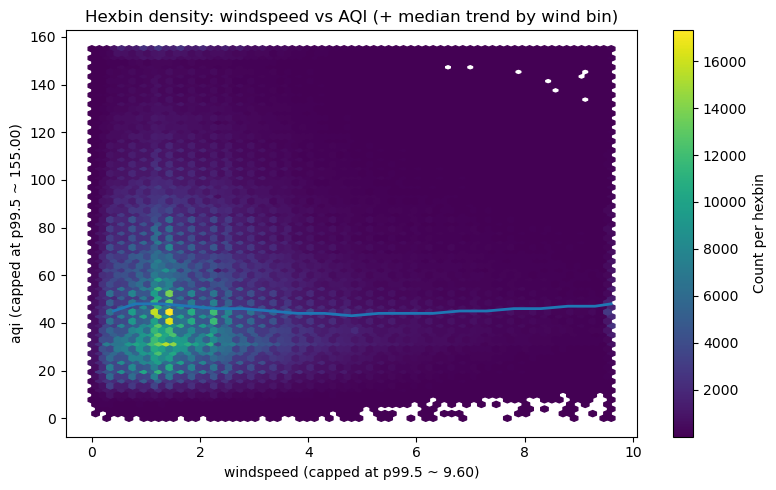

In [9]:
plt.figure(figsize=(8, 5))
plt.hexbin(w_plot, a_plot, gridsize=70, mincnt=1)  # không set màu theo yêu cầu bạn
plt.plot(bin_median_aqi["wind_mid"], bin_median_aqi["aqi_median"], linewidth=2)

plt.xlabel(f"{wind_speed_col} (capped at p99.5 ~ {w_cap:.2f})")
plt.ylabel(f"{target} (capped at p99.5 ~ {a_cap:.2f})")
plt.title("Hexbin density: windspeed vs AQI (+ median trend by wind bin)")
cb = plt.colorbar()
cb.set_label("Count per hexbin")
plt.tight_layout()
plt.show()

- **Mật độ quan sát dồn rất mạnh ở vùng gió yếu (≈ 0–3 m/s).**  
  Đây là “chế độ khí tượng phổ biến” trong dữ liệu theo giờ: đa số thời điểm gió không quá mạnh, nên mọi kết luận tổng thể sẽ bị chi phối chủ yếu bởi vùng này.

- **Ở gần như mọi mức gió, AQI vẫn trải rộng theo trục dọc (phân tán lớn).**  
  Trong hexbin, cùng một windspeed vẫn xuất hiện rất nhiều mức AQI khác nhau → gợi ý **windspeed không phải yếu tố quyết định đơn độc**, và tín hiệu gió dễ bị “che” bởi các yếu tố khác (nguồn phát thải, giờ/ngày, mùa, mưa, nghịch nhiệt, địa hình…).

- **Đường “median trend by wind bin” cho thấy một quan hệ phi tuyến nhẹ (dạng U-shape).**  
  Median AQI **giảm dần** khi gió tăng từ mức thấp lên **gió trung bình**, sau đó **không giảm tiếp** mà **nhích tăng** ở vùng gió mạnh hơn.  
  → Điều này *không giống* quy luật đơn giản “gió càng mạnh thì AQI càng giảm”.

- **Lưu ý kỹ thuật của biểu đồ:** trục x/y đều “cap ở p99.5”, nên phần cực trị bị cắt bớt để nhìn rõ vùng dày dữ liệu. Vì vậy, ta nên diễn giải theo **xu hướng trung tâm** (median line & vùng mật độ chính) hơn là bám vào vài điểm rải rác ở rìa.

**Kết luận rút ra từ Hexbin:**  
Windspeed **có thể liên hệ với AQI theo hướng “gió trung bình giúp AQI tốt hơn một chút”**, nhưng hiệu ứng **yếu và không tuyến tính**, và **không đủ mạnh** để nói rằng gió “làm sạch” một cách rõ rệt trên toàn bộ dữ liệu.

### 1.3 — Xu hướng theo bin windspeed (median/mean AQI)

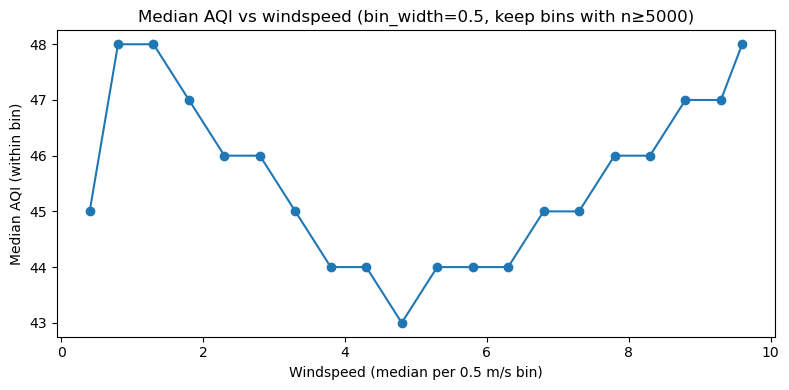

In [10]:
plt.figure(figsize=(8, 4))
plt.plot(bin_median_aqi["wind_mid"], bin_median_aqi["aqi_median"], marker="o")
plt.xlabel(f"Windspeed (median per {bin_width} m/s bin)")
plt.ylabel("Median AQI (within bin)")
plt.title(f"Median AQI vs windspeed (bin_width={bin_width}, keep bins with n≥{min_n_bin})")
plt.tight_layout()
plt.show()

- **Đường median theo bin thể hiện rõ hơn dạng “giảm rồi tăng” (phi tuyến).**  
  Median AQI **cao hơn** ở vùng gió rất yếu, **giảm dần** khi gió tăng đến vùng **~4–5 m/s**, rồi **tăng trở lại** khi gió cao hơn.

- **Có một “điểm đáy” khá rõ quanh ~4.5–5.0 m/s (median AQI thấp nhất).**  
  Đây là tín hiệu quan trọng nhất của tiêu chí 1: nếu muốn mô tả bằng trực giác, thì dữ liệu ủng hộ câu:  
  **“Gió yếu dễ đi kèm AQI cao hơn; gió vừa phải thì AQI điển hình thấp hơn; nhưng gió quá mạnh không đảm bảo AQI tiếp tục giảm.”**

- **Biên độ thay đổi của median nhìn chung không lớn.**  
  Đường median chỉ dao động trong một khoảng hẹp (không tạo “dốc giảm mạnh”), nên về mặt hiệu ứng thực tế, windspeed **chỉ giải thích được một phần rất nhỏ** sự biến động AQI.

- **Phần đuôi gió mạnh (≈ 7–10 m/s) cần cẩn trọng khi diễn giải.**  
  Dù bạn đã lọc bin với n ≥ 5000, gió rất mạnh vẫn là trạng thái hiếm hơn so với gió yếu → median ở vùng này có thể phản ánh “nhóm điều kiện thời tiết đặc thù” (mùa bão, gió mùa, mưa lớn, thay đổi nguồn vận chuyển…) chứ không chỉ là cơ chế khuếch tán đơn giản.

**Kết luận rút ra từ bin windspeed:**  
Nếu chỉ nhìn theo “mức điển hình” (median), tác động của windspeed lên AQI **không tuyến tính** và **tối ưu ở vùng gió trung bình** (xấp xỉ quanh điểm đáy). Điều này ủng hộ ý tưởng rằng muốn tìm “ngưỡng vận hành” thì nên làm ở tiêu chí threshold (tiêu chí 3), chứ **không thể kết luận bằng tương quan tuyến tính**.

### Kết luận cho Tiêu chí 1 
- **Không có bằng chứng cho quy luật đơn giản** “gió càng mạnh → AQI càng giảm” trên toàn cục.  
- **Có tín hiệu phi tuyến nhẹ:** AQI điển hình giảm khi gió từ yếu → trung bình, rồi tăng lại khi gió rất mạnh.  
- **Hiệu ứng tổng thể nhỏ và phân tán lớn**, nên windspeed nên được xem là **tín hiệu bổ trợ** (proxy khí tượng), không phải biến dự đoán mạnh nếu đứng một mình.

## Tiêu chí 2: Hướng gió (sector) ảnh hưởng AQI / rủi ro status xấu
**Mục tiêu.** Vì hướng gió là biến “vòng tròn” (0° ≈ 360°) nên thay vì đo tương quan trực tiếp, ta chia hướng gió thành **16 sector** (mỗi **22.5°**) để so sánh:

- **Median AQI theo sector:** gió “từ hướng nào” thường đi kèm AQI cao/thấp.
- **P(status xấu) theo sector:** gió “từ hướng nào” làm tăng/giảm rủi ro các mức **USG+**.

**Cách đọc.** Nếu một hướng gió cho **median AQI cao** và đồng thời **P(status xấu) cao**, đó là dấu hiệu hướng gió đó thường mang điều kiện bất lợi (có thể do vận chuyển ô nhiễm, địa hình, mùa…).

**Lưu ý:** đây là **mối liên hệ thống kê**, không khẳng định nhân quả.

### 2.1. Bảng `dir_summary_f`  

In [12]:
if wind_dir_col is None:
    print("Khong co cot huong gio -> bo qua Tieu chi 2.")
else:
    n_sectors = 16
    sector_size = 360 / n_sectors

    d3 = d.copy()
    d3["dir_sector"] = (np.floor(d3[wind_dir_col] / sector_size).astype(int)) % n_sectors
    d3["dir_center_deg"] = d3["dir_sector"] * sector_size + sector_size / 2

    agg = {
        "n": (target, "size"),
        "aqi_median": (target, "median"),
        "dir_center_deg": ("dir_center_deg", "first"),
    }
    if "is_bad" in d3.columns:
        agg["p_bad"] = ("is_bad", "mean")

    dir_summary = (
        d3.groupby("dir_sector", observed=True)
          .agg(**agg)
          .reset_index()
          .sort_values("dir_sector")
    )

    min_n_sector = 20000
    dir_summary_f = dir_summary[dir_summary["n"] >= min_n_sector].copy()

`dir_summary_f` là bảng tổng hợp theo *mỗi sector hướng gió* (0..15).  
Nó gom toàn bộ dữ liệu gốc theo `dir_sector` và tính các thống kê đại diện:

- `aqi_median`: median AQI của sector → dùng để vẽ **Plot 2.2 (polar median AQI theo hướng gió)**  
- `p_bad` (nếu có `is_bad`): tỷ lệ status xấu của sector → dùng để vẽ **Plot 2.3 (bar P(status xấu) theo hướng gió)**  
- `dir_center_deg`: góc trung tâm của sector → để đặt vị trí trên vòng tròn ở plot polar  
- `n`: số mẫu trong sector → dùng để lọc bỏ sector quá ít dữ liệu (tránh nhiễu)

Tóm lại: `dir_summary_f` là “dataset đã nén” từ hàng triệu dòng xuống 16 dòng (16 sector),
giúp so sánh AQI và rủi ro theo hướng gió một cách rõ ràng và ổn định hơn.

### 2.2. Plot “Median AQI theo hướng gió”

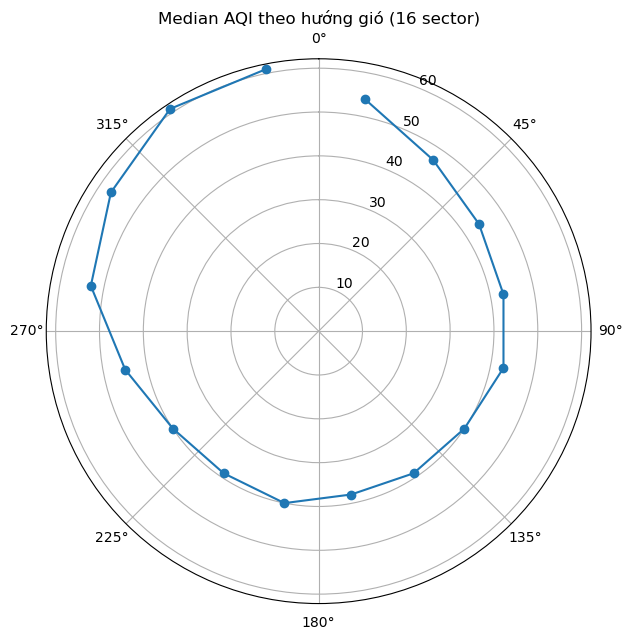

In [13]:
theta = np.deg2rad(dir_summary_f["dir_center_deg"].to_numpy())
r = dir_summary_f["aqi_median"].to_numpy()

fig = plt.figure(figsize=(6.5, 6.5))
ax = fig.add_subplot(111, projection="polar")
ax.plot(theta, r, marker="o")
ax.set_title("Median AQI theo hướng gió (16 sector)")
ax.set_theta_zero_location("N")   # 0 độ ở hướng Bắc
ax.set_theta_direction(-1)        # xoay theo chiều kim đồng hồ
plt.tight_layout()
plt.show()

### Nhận xét Median AQI theo hướng gió (16 sector)

- Đường polar tạo thành **một “thung lũng” rất rõ ở nửa Nam**: từ khoảng **150° → 210°** (các sector quanh 6–9), median AQI nằm **thấp nhất** và khá “phẳng” (ít dao động).  
  → Đây là nhóm hướng gió **thuận lợi**, thường đi kèm điều kiện AQI tốt hơn.

- Ngược lại, đường cong **leo dốc mạnh khi chuyển sang nửa Tây–Bắc** và đạt **đỉnh ở vùng ~300° → 360°** (các sector 13–15).  
  → Đây là nhóm hướng gió **bất lợi**, median AQI cao rõ rệt so với vùng “thung lũng” phía Nam.

- Biên độ giữa đáy–đỉnh trên plot là **rất lớn** (nhìn bằng mắt đã thấy chênh rõ ràng), nên **hướng gió mang tín hiệu rủi ro mạnh** hơn nhiều so với “tương quan tổng thể” giữa windspeed và AQI.

> Ý nghĩa: Nếu coi hướng gió là “điều kiện khí tượng nền”, thì trong dữ liệu này có những hướng gió đi kèm trạng thái không khí **tốt một cách nhất quán** (nửa Nam), và có những hướng gió đi kèm **AQI cao** một cách rõ rệt (Tây–Tây Bắc–Bắc).

### 2.3. Plot “P(status xấu) theo hướng gió”  

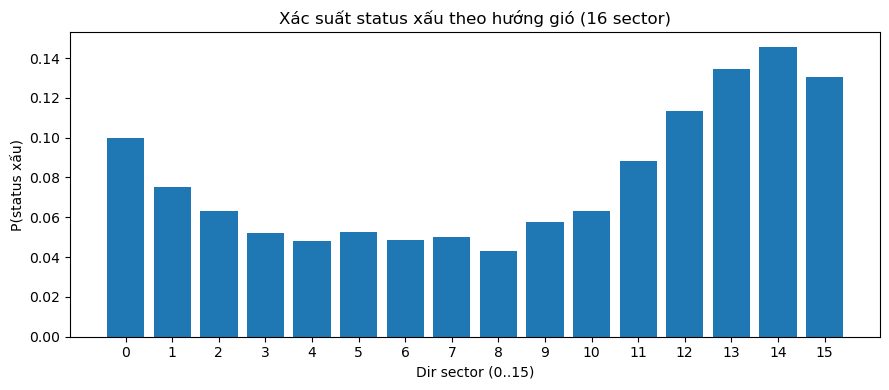

In [14]:
if "p_bad" in dir_summary_f.columns:
    plt.figure(figsize=(9, 4))
    plt.bar(dir_summary_f["dir_sector"].astype(str), dir_summary_f["p_bad"])
    plt.xlabel("Dir sector (0..15)")
    plt.ylabel("P(status xấu)")
    plt.title("Xác suất status xấu theo hướng gió (16 sector)")
    plt.tight_layout()
    plt.show()

### Nhận xét P(status xấu) theo hướng gió (16 sector)

- Biểu đồ cột cho thấy **mẫu hình gần như trùng khớp với Plot 2.2**:
  - Các sector ở nửa Nam (đặc biệt quanh **sector 8**) có **P(status xấu) thấp nhất** (cột thấp nhất).
  - Từ khoảng **sector 11 trở đi**, xác suất status xấu **tăng nhanh**, và đạt **đỉnh rõ rệt ở sector 14**, sau đó vẫn **cao** ở sector 13 và 15.

- Điều quan trọng là không chỉ “AQI median cao hơn”, mà **rủi ro rơi vào nhóm xấu cũng tăng mạnh** theo cùng một hướng gió.  
  → Đây là bằng chứng trực quan rằng **hướng gió không chỉ làm dịch chuyển giá trị AQI**, mà còn làm thay đổi **xác suất xảy ra các trạng thái rủi ro**.

> Ý nghĩa vận hành: Khi gió rơi vào nhóm hướng “bất lợi” (Tây–Tây Bắc–Bắc), hệ thống có thể xem đây là **tín hiệu cảnh báo sớm** (risk indicator) cho USG+.

---

### Kết luận gộp từ 2 plot 

- Hai plot nhất quán với nhau: **nửa Nam = thuận lợi (AQI thấp & rủi ro thấp)**, còn **Tây–Tây Bắc–Bắc = bất lợi (AQI cao & rủi ro cao)**.  
- Vì đây là thống kê theo nhóm hướng (sector), kết luận nên trình bày ở mức **liên hệ/association** (không khẳng định nhân quả): hướng gió có thể đang “đại diện” cho cơ chế **vận chuyển ô nhiễm + điều kiện khuếch tán + bối cảnh địa lý/mùa**.

## Tiêu chí 3: Quét ngưỡng windspeed cho (a) median AQI và (b) P(status xấu)
### Mục tiêu
Thay vì giả định quan hệ tuyến tính giữa **windspeed** và **AQI**, tiêu chí này tìm một **ngưỡng t (m/s)** sao cho việc chia dữ liệu thành 2 nhóm:

- **Nhóm 1:** windspeed < t  
- **Nhóm 2:** windspeed ≥ t  

tạo ra **độ tách (separation)** lớn nhất về:
- **(a) Median AQI**  → đo bằng `delta_median`
- **(b) Rủi ro status xấu (USG+)** → đo bằng `delta_p_bad` (nếu có `is_bad`)

Trong đó:
- `delta_median = median(AQI|wind<t) - median(AQI|wind>=t)`  
- `delta_p_bad = P(bad|wind<t) - P(bad|wind>=t)`  
Giá trị **dương** nghĩa là: **gió mạnh hơn (≥ t) đi kèm AQI thấp hơn / rủi ro thấp hơn**.

> Đặt điều kiện `min_frac_each_side = 0.10` để tránh ngưỡng quá lệch (mỗi phía phải có ≥ 10% dữ liệu), giúp kết luận “vận hành” đúng dữ liệu.

### 3.1. Bảng threshold (thr_by_median & thr_by_risk)

In [17]:
cand_t = bin_median_aqi["wind_mid"].to_numpy()  # dùng ngưỡng từ bin median (ổn định hơn giá trị thô)

w = d[wind_speed_col].to_numpy()
aqi = d[target].to_numpy()
bad = d["is_bad"].to_numpy() if "is_bad" in d.columns else None

min_frac_each_side = 0.10
rows = []

for t in cand_t:
    left = w < t
    frac = left.mean()
    if frac < min_frac_each_side or frac > (1 - min_frac_each_side):
        continue

    dm = float(np.nanmedian(aqi[left]) - np.nanmedian(aqi[~left]))
    row = {"t": float(t), "delta_median": dm}

    if bad is not None:
        dp = float(bad[left].mean() - bad[~left].mean())
        row["delta_p_bad"] = dp

    rows.append(row)

thr_df = pd.DataFrame(rows).sort_values("t")

#### Bảng threshold:
- **Sinh danh sách ngưỡng ứng viên `cand_t`** từ `wind_mid` (median windspeed của từng bin) thay vì quét từng giá trị windspeed thô  
  → giúp ngưỡng **ổn định hơn**, ít nhiễu và giảm số lượng ngưỡng cần thử.

- **Chuẩn bị mảng dữ liệu nhanh để tính toán** (`w`, `aqi`, và `bad` nếu có)  
  → tránh thao tác DataFrame trong vòng lặp, chạy nhanh hơn trên dữ liệu lớn.

- **Ràng buộc `min_frac_each_side = 0.10`**  
  → loại các ngưỡng làm dữ liệu chia quá lệch (một phía < 10%), tránh kết luận “ngưỡng” dựa trên **đuôi hiếm**.

- Với mỗi ngưỡng `t`, code **chia dữ liệu thành 2 nhóm**:
  - Nhóm gió yếu: `wind < t`
  - Nhóm gió mạnh: `wind >= t`

- **Tính độ tách (separation) theo ngưỡng**:
  - `delta_median = median(AQI | wind<t) - median(AQI | wind>=t)`  
    → **dương** nghĩa là khi gió mạnh (>=t) thì AQI median **thấp hơn** (tín hiệu “gió giúp sạch” theo ngưỡng).
  - Nếu có `is_bad`: `delta_p_bad = P(bad|wind<t) - P(bad|wind>=t)`  
    → **dương** nghĩa là gió mạnh (>=t) đi kèm **giảm rủi ro** status xấu.

- **Kết quả cuối cùng `thr_df`** là bảng gồm các ngưỡng `t` và các chỉ số tách (`delta_median`, `delta_p_bad`)  
  → dùng trực tiếp để **vẽ Plot 3.2 và Plot 3.3** và chọn ngưỡng “tốt nhất”.

### 3.2. Độ tách median AQI và Độ tách rủi ro status xấu theo ngưỡng windspeed

In [ ]:
# Plot delta_median theo t
plt.figure(figsize=(8.5, 4))
plt.plot(thr_df["t"], thr_df["delta_median"], marker="o")
plt.xlabel("Threshold t (m/s)")
plt.ylabel("delta_median = median(AQI|wind<t) - median(AQI|wind>=t)")
plt.title("Độ tách median AQI theo ngưỡng windspeed")
plt.tight_layout()
plt.show()

# Plot delta_p_bad theo t 
if "delta_p_bad" in thr_df.columns:
    plt.figure(figsize=(8.5, 4))
    plt.plot(thr_df["t"], thr_df["delta_p_bad"], marker="o")
    plt.xlabel("Threshold t (m/s)")
    plt.ylabel("delta_p_bad = P(bad|wind<t) - P(bad|wind>=t)")
    plt.title("Độ tách rủi ro status xấu theo ngưỡng windspeed")
    plt.tight_layout()
    plt.show()

#### Nhận xét Plot "Độ tách median AQI theo ngưỡng windspeed (delta_median)"

- Ở ngưỡng rất thấp (~0.8 m/s), **delta_median ≈ 0**: tách “gió cực yếu” vs “còn lại” gần như không tạo khác biệt median AQI.
- Khi tăng ngưỡng lên khoảng **1.3 → 1.8 m/s**, delta_median **tăng nhanh** (lên ~1 rồi ~2): chỉ cần vượt khỏi vùng gió yếu là median AQI đã “dịch” xuống một mức.
- Từ khoảng **1.8 → 3.3 m/s**, đường cong gần như **plateau** (giữ quanh ~2): tăng ngưỡng trong vùng này không giúp tách median tốt hơn.
- Tại khoảng **3.8 m/s**, xuất hiện **bước nhảy** lên mức cao nhất (~3): đây là **breakpoint rõ nhất** trong các ngưỡng được quét.

> Diễn giải vận hành: nếu cần một ngưỡng “có ý nghĩa tách nhóm”, vùng ~3–4 m/s nổi bật nhất; còn 1.8–3.3 m/s cho hiệu ứng ổn nhưng bão hòa.

#### Nhận xét Plot "Độ tách rủi ro status xấu theo ngưỡng windspeed (delta_p_bad)"

- Ở ngưỡng thấp (~0.8 m/s), **delta_p_bad âm nhẹ**: chọn ngưỡng này không có lợi (nhóm gió mạnh hơn không giảm rủi ro, thậm chí nhỉnh hơn một chút).
- Từ **~1.3 m/s trở lên**, delta_p_bad chuyển sang **dương và tăng đều** theo ngưỡng: ngưỡng càng cao thì chênh rủi ro giữa (gió yếu) và (gió mạnh) càng rõ.
- **Đỉnh lớn nhất ở ~3.8 m/s**: đây là điểm cho thấy “gió mạnh (≥t)” gắn với **giảm rủi ro status xấu** rõ nhất trong các ứng viên.

> Takeaway: dù tương quan toàn cục gần 0, cách nhìn theo **threshold** cho thấy có thể chọn t để “tách rủi ro” tốt — và t quanh ~3.8 m/s là ứng viên mạnh nhất trong kết quả hiện tại.

### Câu 6 (Chốt): Windspeed + wind direction có giúp nhận diện rủi ro AQI / status xấu không?

#### (1) Kết quả từ Tiêu chí 1 — windspeed ↔ AQI (hexbin + theo bin)
- Dữ liệu dồn cực mạnh ở vùng gió yếu (≈ 0–3 m/s), và tại gần như mọi mức gió thì AQI vẫn **phân tán rất rộng** → windspeed **không phải yếu tố quyết định đơn độc**.
- Đường median theo bin cho thấy quan hệ **phi tuyến nhẹ (giảm rồi tăng)**: AQI điển hình giảm khi gió từ yếu → trung bình, sau đó **không giảm tiếp** (thậm chí nhích tăng ở vùng gió rất mạnh).
→ Kết luận: nếu chỉ dùng “tương quan tuyến tính” thì tín hiệu yếu; windspeed chỉ nên xem là **tín hiệu bổ trợ** và cần phân tích theo nhóm (bin/threshold).

#### (2) Kết quả từ Tiêu chí 2 — wind direction (sector) là tín hiệu mạnh nhất
- Khi chia hướng gió thành 16 sector, cả 2 plot đều cho thấy mẫu hình **rất rõ**:
  - Một số hướng gió tạo “vùng thuận lợi” với **median AQI thấp** và **P(status xấu) thấp**.
  - Một số hướng gió tạo “vùng bất lợi” với **median AQI cao** và **P(status xấu) cao**.
→ Kết luận: **wind direction mang thông tin rủi ro mạnh hơn nhiều** so với windspeed nếu nhìn toàn cục.

#### (3) Kết quả từ Tiêu chí 3 — windspeed hữu ích khi dùng theo “ngưỡng t”
- Khi quét ngưỡng t để chia dữ liệu thành 2 nhóm (wind < t và wind ≥ t), các plot delta cho thấy tồn tại **breakpoint tốt nhất**:
  - Ở khoảng **t ≈ 3.8 m/s**, độ tách đạt lớn nhất:
    - `delta_median > 0` → nhóm gió mạnh có median AQI thấp hơn.
    - `delta_p_bad > 0` (nếu có is_bad) → nhóm gió mạnh có rủi ro status xấu thấp hơn.
→ Kết luận: windspeed vẫn có giá trị “vận hành” nếu dùng theo **threshold**, thay vì đo tuyến tính.

#### (4) Kết luận cuối cho Câu 6 (không overclaim)
**Có.** Dù tương quan tổng thể rất nhỏ/không rõ ràng, cách phân tích theo nhóm cho thấy:
- **Wind direction** là tín hiệu rủi ro chính (tách AQI và P(status xấu) rất rõ theo sector).
- **Windspeed** là tín hiệu bổ trợ: có thể chọn **ngưỡng ~3–4 m/s (đặc biệt ~3.8 m/s)** để tách nhóm “rủi ro cao” vs “rủi ro thấp” tốt hơn.

Lưu ý diễn giải: đây là **liên hệ thống kê (association)**, chưa chứng minh nhân quả vì còn nhiều yếu tố nhiễu (mùa/giờ/mưa/địa hình/nguồn thải). 